In [1]:
#%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

# Enrichment Analysis Visualizer

This appyter creates a variety of visualizations for enrichment analysis results for one selected Enrichr library, and may be run as either a standalone appyter from the [Appyter Catalog](https://appyters.maayanlab.cloud/#/Enrichment_Analysis_Visualizer) or programmatically from the [Enrichr](https://maayanlab.cloud/Enrichr/) results page. 

For simplicity, the only inputs for this appyter are a gene list and one library. Other parameters are set to default values in the cell below. You can download the notebook, change these parameters, and rerun it if you wish.

The pre-processed libraries used to create the scatter plot and hexagonal canvas visualizations can be found [here](https://github.com/MaayanLab/Enrichr-Viz-Appyter/tree/master/Enrichr-Processed-Library-Storage). 

**A link to the full analysis results on the Enrichr website can be found at the bottom of this page.**

In [2]:
# Scatter Plot Imports
from maayanlab_bioinformatics.enrichment import enrich_crisp
import matplotlib as mpl
import matplotlib.colors as colors

# Bar Chart Imports
import pandas as pd 
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import time
from matplotlib.ticker import MaxNLocator
from IPython.display import display, FileLink, Markdown, HTML

# Hexagonal Canvas Imports
import json
import math
import uuid
import urllib
from textwrap import dedent
from string import Template
from operator import itemgetter

# Manhattan Plot Imports
import matplotlib.patches as mpatches
import matplotlib.cm as cm

# Bokeh
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import HoverTool, CustomJS, ColumnDataSource, Span
from bokeh.layouts import layout, row, column, gridplot
from bokeh.palettes import all_palettes
output_notebook()

Loading BokehJS ...

In [3]:
%%appyter hide_code

{% do SectionField(
    name='section1', 
    title = '1. Submit Your Gene List', 
    subtitle = 'Upload a text file containing your gene list or copy and paste your gene list into the text box below (One gene per row). You can also try the default gene list provided.', 
    img = 'enrichr-icon.png'
) %}
{% do SectionField(
    name='section2', 
    title = '2. Choose Enrichr Library', 
    subtitle = 'Select one Enrichr library.', 
    img = 'enrichr-icon.png'
) %}

In [4]:
%%appyter hide_code

{% set gene_list_kind = TabField(
    name='gene_list_kind',
    label='Gene List',
    default='Paste',
    description='Paste or upload your gene list',
    required=True,
    choices={
        'Paste': [
            TextField(
                name='gene_list_input',
                label='Gene List',
                constraint='[A-Za-z0-9\-\.]+[\n]*',
                default='NSUN3\nPOLRMT\nNLRX1\nSFXN5\nZC3H12C\nSLC25A39\nARSG\nDEFB29\nNDUFB6\nZFAND1\nTMEM77\n5730403B10RIK\nRP23-195K8.6\nTLCD1\nPSMC6\nSLC30A6\nLOC100047292\nLRRC40\nORC5L\nMPP7\nUNC119B\nPRKACA\nTCN2\nPSMC3IP\nPCMTD2\nACAA1A\nLRRC1\n2810432D09RIK\nSEPHS2\nSAC3D1\nTMLHE\nLOC623451\nTSR2\nPLEKHA7\nGYS2\nARHGEF12\nHIBCH\nLYRM2\nZBTB44\nENTPD5\nRAB11FIP2\nLIPT1\nINTU\nANXA13\nKLF12\nSAT2\nGAL3ST2\nVAMP8\nFKBPL\nAQP11\nTRAP1\nPMPCB\nTM7SF3\nRBM39\nBRI3\nKDR\nZFP748\nNAP1L1\nDHRS1\nLRRC56\nWDR20A\nSTXBP2\nKLF1\nUFC1\nCCDC16\n9230114K14RIK\nRWDD3\n2610528K11RIK\nACO1\nCABLES1\nLOC100047214\nYARS2\nLYPLA1\nKALRN\nGYK\nZFP787\nZFP655\nRABEPK\nZFP650\n4732466D17RIK\nEXOSC4\nWDR42A\nGPHN\n2610528J11RIK\n1110003E01RIK\nMDH1\n1200014M14RIK\nAW209491\nMUT\n1700123L14RIK\n2610036D13RIK\nCOX15\nTMEM30A\nNSMCE4A\nTM2D2\nRHBDD3\nATXN2\nNFS1\n3110001I20RIK\nBC038156\nLOC100047782\n2410012H22RIK\nRILP\nA230062G08RIK\nPTTG1IP\nRAB1\nAFAP1L1\nLYRM5\n2310026E23RIK\nC330002I19RIK\nZFYVE20\nPOLI\nTOMM70A\nSLC7A6OS\nMAT2B\n4932438A13RIK\nLRRC8A\nSMO\nNUPL2\nTRPC2\nARSK\nD630023B12RIK\nMTFR1\n5730414N17RIK\nSCP2\nZRSR1\nNOL7\nC330018D20RIK\nIFT122\nLOC100046168\nD730039F16RIK\nSCYL1\n1700023B02RIK\n1700034H14RIK\nFBXO8\nPAIP1\nTMEM186\nATPAF1\nLOC100046254\nLOC100047604\nCOQ10A\nFN3K\nSIPA1L1\nSLC25A16\nSLC25A40\nRPS6KA5\nTRIM37\nLRRC61\nABHD3\nGBE1\nPARP16\nHSD3B2\nESM1\nDNAJC18\nDOLPP1\nLASS2\nWDR34\nRFESD\nCACNB4\n2310042D19RIK\nSRR\nBPNT1\n6530415H11RIK\nCLCC1\nTFB1M\n4632404H12RIK\nD4BWG0951E\nMED14\nADHFE1\nTHTPA\nCAT\nELL3\nAKR7A5\nMTMR14\nTIMM44\nSF1\nIPP\nIAH1\nTRIM23\nWDR89\nGSTZ1\nCRADD\n2510006D16RIK\nFBXL6\nLOC100044400\nZFP106\nCD55\n0610013E23RIK\nAFMID\nTMEM86A\nALDH6A1\nDALRD3\nSMYD4\nNME7\nFARS2\nTASP1\nCLDN10\nA930005H10RIK\nSLC9A6\nADK\nRBKS\n2210016F16RIK\nVWCE\n4732435N03RIK\nZFP11\nVLDLR\n9630013D21RIK\n4933407N01RIK\nFAHD1\nMIPOL1\n1810019D21RIK\n1810049H13RIK\nTFAM\nPAICS\n1110032A03RIK\nLOC100044139\nDNAJC19\nBC016495\nA930041I02RIK\nRQCD1\nUSP34\nZCCHC3\nH2AFJ\nPHF7\n4921508D12RIK\nKMO\nPRPF18\nMCAT\nTXNDC4\n4921530L18RIK\nVPS13B\nSCRN3\nTOR1A\nAI316807\nACBD4\nFAH\nAPOOL\nCOL4A4\nLRRC19\nGNMT\nNR3C1\nSIP1\nASCC1\nFECH\nABHD14A\nARHGAP18\n2700046G09RIK\nYME1L1\nGK5\nGLO1\nSBK1\nCISD1\n2210011C24RIK\nNXT2\nNOTUM\nANKRD42\nUBE2E1\nNDUFV1\nSLC33A1\nCEP68\nRPS6KB1\nHYI\nALDH1A3\nMYNN\n3110048L19RIK\nRDH14\nPROZ\nGORASP1\nLOC674449\nZFP775\n5430437P03RIK\nNPY\nADH5\nSYBL1\n4930432O21RIK\nNAT9\nLOC100048387\nMETTL8\nENY2\n2410018G20RIK\nPGM2\nFGFR4\nMOBKL2B\nATAD3A\n4932432K03RIK\nDHTKD1\nUBOX5\nA530050D06RIK\nZDHHC5\nMGAT1\nNUDT6\nTPMT\nWBSCR18\nLOC100041586\nCDK5RAP1\n4833426J09RIK\nMYO6\nCPT1A\nGADD45GIP1\nTMBIM4\n2010309E21RIK\nASB9\n2610019F03RIK\n7530414M10RIK\nATP6V1B2\n2310068J16RIK\nDDT\nKLHDC4\nHPN\nLIFR\nOVOL1\nNUDT12\nCDAN1\nFBXO9\nFBXL3\nHOXA7\nALDH8A1\n3110057O12RIK\nABHD11\nPSMB1\nENSMUSG00000074286\nCHPT1\nOXSM\n2310009A05RIK\n1700001L05RIK\nZFP148\n39509\nMRPL9\nTMEM80\n9030420J04RIK\nNAGLU\nPLSCR2\nAGBL3\nPEX1\nCNO\nNEO1\nASF1A\nTNFSF5IP1\nPKIG\nAI931714\nD130020L05RIK\nCNTD1\nCLEC2H\nZKSCAN1\n1810044D09RIK\nMETTL7A\nSIAE\nFBXO3\nFZD5\nTMEM166\nTMED4\nGPR155\nRNF167\nSPTLC1\nRIOK2\nTGDS\nPMS1\nPITPNC1\nPCSK7\n4933403G14RIK\nEI24\nCREBL2\nTLN1\nMRPL35\n2700038C09RIK\nUBIE\nOSGEPL1\n2410166I05RIK\nWDR24\nAP4S1\nLRRC44\nB3BP\nITFG1\nDMXL1\nC1D',
                description='Paste your gene list (One gene per row).',
                section='section1'
            ),
        ],
        'Upload': [
            FileField(
                name='gene_list_filename',
                label='Gene List File',
                default='',
                description='Upload your gene list as a text file (One gene per row).',
                section='section1'
            ),
        ],
    },
    section = 'section1',
) %}

{% set enrichr_library = AutocompleteField(
    name='enrichr_library',
    description='Select one Enrichr library for which to create visualizations.', 
    label='Enrichr Library', 
    default='WikiPathways_2019_Human', 
    section='section2',
    file_path='https://appyters.maayanlab.cloud/storage/Enrichment_Analysis_Visualizer/enrichr_libraries.json'
) %}

In [5]:
%%appyter code_exec

{%- if gene_list_kind.raw_value == 'Paste' %}
gene_list_input = {{ gene_list_kind.value[0] }}
{%- else %}
gene_list_filename = {{ gene_list_kind.value[0] }}
{%- endif %}
enrichr_library = {{ enrichr_library }}

```python
gene_list_input = '''NSUN3
POLRMT
NLRX1
SFXN5
ZC3H12C
SLC25A39
ARSG
DEFB29
NDUFB6
ZFAND1
TMEM77
5730403B10RIK
RP23-195K8.6
TLCD1
PSMC6
SLC30A6
LOC100047292
LRRC40
ORC5L
MPP7
UNC119B
PRKACA
TCN2
PSMC3IP
PCMTD2
ACAA1A
LRRC1
2810432D09RIK
SEPHS2
SAC3D1
TMLHE
LOC623451
TSR2
PLEKHA7
GYS2
ARHGEF12
HIBCH
LYRM2
ZBTB44
ENTPD5
RAB11FIP2
LIPT1
INTU
ANXA13
KLF12
SAT2
GAL3ST2
VAMP8
FKBPL
AQP11
TRAP1
PMPCB
TM7SF3
RBM39
BRI3
KDR
ZFP748
NAP1L1
DHRS1
LRRC56
WDR20A
STXBP2
KLF1
UFC1
CCDC16
9230114K14RIK
RWDD3
2610528K11RIK
ACO1
CABLES1
LOC100047214
YARS2
LYPLA1
KALRN
GYK
ZFP787
ZFP655
RABEPK
ZFP650
4732466D17RIK
EXOSC4
WDR42A
GPHN
2610528J11RIK
1110003E01RIK
MDH1
1200014M14RIK
AW209491
MUT
1700123L14RIK
2610036D13RIK
COX15
TMEM30A
NSMCE4A
TM2D2
RHBDD3
ATXN2
NFS1
3110001I20RIK
BC038156
LOC100047782
2410012H22RIK
RILP
A230062G08RIK
PTTG1IP
RAB1
AFAP1L1
LYRM5
2310026E23RIK
C330002I19RIK
ZFYVE20
POLI
TOMM70A
SLC7A6OS
MAT2B
4932438A13RIK
LRRC8A
SMO
NUPL2
TRPC2
ARSK
D630023B12RIK
MTFR1
5730414N17RIK
SCP2
ZRSR1
NOL7
C330018D20RIK
IFT122
LOC100046168
D730039F16RIK
SCYL1
1700023B02RIK
1700034H14RIK
FBXO8
PAIP1
TMEM186
ATPAF1
LOC100046254
LOC100047604
COQ10A
FN3K
SIPA1L1
SLC25A16
SLC25A40
RPS6KA5
TRIM37
LRRC61
ABHD3
GBE1
PARP16
HSD3B2
ESM1
DNAJC18
DOLPP1
LASS2
WDR34
RFESD
CACNB4
2310042D19RIK
SRR
BPNT1
6530415H11RIK
CLCC1
TFB1M
4632404H12RIK
D4BWG0951E
MED14
ADHFE1
THTPA
CAT
ELL3
AKR7A5
MTMR14
TIMM44
SF1
IPP
IAH1
TRIM23
WDR89
GSTZ1
CRADD
2510006D16RIK
FBXL6
LOC100044400
ZFP106
CD55
0610013E23RIK
AFMID
TMEM86A
ALDH6A1
DALRD3
SMYD4
NME7
FARS2
TASP1
CLDN10
A930005H10RIK
SLC9A6
ADK
RBKS
2210016F16RIK
VWCE
4732435N03RIK
ZFP11
VLDLR
9630013D21RIK
4933407N01RIK
FAHD1
MIPOL1
1810019D21RIK
1810049H13RIK
TFAM
PAICS
1110032A03RIK
LOC100044139
DNAJC19
BC016495
A930041I02RIK
RQCD1
USP34
ZCCHC3
H2AFJ
PHF7
4921508D12RIK
KMO
PRPF18
MCAT
TXNDC4
4921530L18RIK
VPS13B
SCRN3
TOR1A
AI316807
ACBD4
FAH
APOOL
COL4A4
LRRC19
GNMT
NR3C1
SIP1
ASCC1
FECH
ABHD14A
ARHGAP18
2700046G09RIK
YME1L1
GK5
GLO1
SBK1
CISD1
2210011C24RIK
NXT2
NOTUM
ANKRD42
UBE2E1
NDUFV1
SLC33A1
CEP68
RPS6KB1
HYI
ALDH1A3
MYNN
3110048L19RIK
RDH14
PROZ
GORASP1
LOC674449
ZFP775
5430437P03RIK
NPY
ADH5
SYBL1
4930432O21RIK
NAT9
LOC100048387
METTL8
ENY2
2410018G20RIK
PGM2
FGFR4
MOBKL2B
ATAD3A
4932432K03RIK
DHTKD1
UBOX5
A530050D06RIK
ZDHHC5
MGAT1
NUDT6
TPMT
WBSCR18
LOC100041586
CDK5RAP1
4833426J09RIK
MYO6
CPT1A
GADD45GIP1
TMBIM4
2010309E21RIK
ASB9
2610019F03RIK
7530414M10RIK
ATP6V1B2
2310068J16RIK
DDT
KLHDC4
HPN
LIFR
OVOL1
NUDT12
CDAN1
FBXO9
FBXL3
HOXA7
ALDH8A1
3110057O12RIK
ABHD11
PSMB1
ENSMUSG00000074286
CHPT1
OXSM
2310009A05RIK
1700001L05RIK
ZFP148
39509
MRPL9
TMEM80
9030420J04RIK
NAGLU
PLSCR2
AGBL3
PEX1
CNO
NEO1
ASF1A
TNFSF5IP1
PKIG
AI931714
D130020L05RIK
CNTD1
CLEC2H
ZKSCAN1
1810044D09RIK
METTL7A
SIAE
FBXO3
FZD5
TMEM166
TMED4
GPR155
RNF167
SPTLC1
RIOK2
TGDS
PMS1
PITPNC1
PCSK7
4933403G14RIK
EI24
CREBL2
TLN1
MRPL35
2700038C09RIK
UBIE
OSGEPL1
2410166I05RIK
WDR24
AP4S1
LRRC44
B3BP
ITFG1
DMXL1
C1D'''
enrichr_library = 'WikiPathways_2019_Human'
```

In [6]:
%%appyter code_exec

{%- if gene_list_kind.raw_value == 'Paste' %}
genes = gene_list_input.split('\n')
genes = [x.strip() for x in genes]
{%- else %}
open_gene_list_file = open(gene_list_filename,'r')
lines = open_gene_list_file.readlines()
genes = [x.strip() for x in lines]
open_gene_list_file.close()
{%- endif %}

```python
genes = gene_list_input.split('\n')
genes = [x.strip() for x in genes]
```

In [7]:
# Error handling
class NoResults(Exception):
    pass 
class APIFailure(Exception):
    pass

In [8]:
# Enrichr API Function for Manhattan Plot and Bar Chart
# Takes a gene list and Enrichr libraries as input
def Enrichr_API(enrichr_gene_list, all_libraries):

    all_terms = []
    all_pvalues =[] 
    all_adjusted_pvalues = []

    for library_name in all_libraries : 
        ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/addList'
        genes_str = '\n'.join(enrichr_gene_list)
        description = ''
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }

        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise APIFailure

        data = json.loads(response.text)
        time.sleep(0.5)
        ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        user_list_id = data['userListId']
        short_id = data["shortId"]
        gene_set_library = library_name
        response = requests.get(
            ENRICHR_URL + query_string % (user_list_id, gene_set_library)
         )
        if not response.ok:
            raise APIFailure

        data = json.loads(response.text)

        if len(data[library_name]) == 0:
            raise NoResults

        short_results_df  = pd.DataFrame(data[library_name][0:10])
        all_terms.append(list(short_results_df[1]))
        all_pvalues.append(list(short_results_df[2]))
        all_adjusted_pvalues.append(list(short_results_df[6]))
        
        results_df  = pd.DataFrame(data[library_name])
        # adds library name to the data frame so the libraries can be distinguished
        results_df['library'] = library_name.replace('_', '')

    return [results_df, short_results_df, all_terms, all_pvalues, all_adjusted_pvalues, str(short_id)]

In [9]:
# Scatter Plot Parameters
significance_value = 0.05

# Bar Chart Parameters
figure_file_format = ['png', 'svg']
output_file_name = 'Enrichr_results_bar'
color = 'lightskyblue'
final_output_file_names = ['{0}.{1}'.format(output_file_name, file_type) for file_type in figure_file_format]

# Hexagonal Canvas Parameters
canvas_color = 'Blue'
num_hex_colored = 10

# Manhattan Plot Parameters
manhattan_colors = ['#003f5c', '#7a5195', '#ef5675', '#ffa600']

# Scatter Plot

The scatterplot is organized so that simliar gene sets are clustered together.
The larger blue points represent significantly enriched terms - the darker the blue, the more significant the term and the smaller the p-value. The gray points are not significant. 

Hovering over points will display the associated gene set name and the p-value. You may have to zoom in using the toolbar next to the plot in order to see details in densely-populated portions. Plots can also be downloaded as an svg using the save function on the toolbar.

For creating and comparing up to 9 scatter plots at once, use the standalone [Scatter Plot Visualization Appyter](https://appyters.maayanlab.cloud/#Enrichr_Scatterplot_Appyter).

In [10]:
# Scatter Plot Functions

def download_library(library_name):
    # Download pre-processed library data
    try:
        df = pd.read_csv('https://raw.githubusercontent.com/MaayanLab/Enrichr-Viz-Appyter/master/Enrichr-Processed-Library-Storage/Scatterplot/Libraries/' + library_name + '.csv')
    except:
        display(HTML("<div style='font-size:1.5rem; padding:1.5rem 0;'>Failed to retrieve the selected pre-processed library.</div>"))
        return -1, -1, -1

    name = df['Name'].tolist()
    gene_list = df['Genes'].tolist()
    library_data = [list(a) for a in zip(name, gene_list)]
    return genes, library_data, df

# Enrichment analysis
def get_library_iter(library_data):
    for member in library_data:
        term = member[0]
        try:
            gene_set = member[1].split(' ')
        except:
            continue
        yield term, gene_set

def get_enrichment_results(genes, library_data):
    return sorted(enrich_crisp(genes, get_library_iter(library_data), 20000, True), key=lambda r: r[1].pvalue)

def get_pvalue(row, unzipped_results, all_results):
    if row['Name'] in list(unzipped_results[0]):
        index = list(unzipped_results[0]).index(row['Name'])
        return all_results[index][1].pvalue
    else:
        return 1
    
def get_colors(data_df, annotated):
    '''
    Return list of hexcodes corresponding to color of each point to be plotted, 
    representing each geneset in data_df. Color schemes will be determined by 
    library annotations (if any).
    '''
    clist = []
    if annotated:
        cmap = mpl.cm.get_cmap('gist_ncar')
        norm = colors.Normalize(vmin = data_df['Color'].min(), vmax=data_df['Color'].max())
        for index, row in data_df.iterrows():
            if row['p value'] < significance_value:
                clist.append(colors.to_hex(cmap(norm(row['Color']))))
            else:
                clist.append(colors.to_hex(cmap(norm(row['Color']))) + '66')
    else:
        cmap = mpl.cm.get_cmap('Blues_r')
        norm = colors.Normalize(vmin = data_df['p value'].min(), vmax=significance_value*2)
        for index, row in data_df.iterrows():
            if row['p value'] < significance_value:
                clist.append(colors.to_hex(cmap(norm(row['p value']))))
            else:
                clist.append('#808080')
    return clist

def get_sizes(data_df):
    '''
    Return list of point sizes corresponding to each point, representing
    each geneset in data_df. Genesets that are significantly enriched will
    have larger point sizes.
    '''
    slist = []
    for index, row in data_df.iterrows():
        if row['p value'] < significance_value:
            slist.append(14)
        else:
            slist.append(6)
    return slist

# Call enrichment results and return a plot and dataframe for Scatter Plot
def get_plot(library_name):
    genes, library_data, df = download_library(library_name)

    # library not supported
    if genes == -1:
        return -1 ,-1

    all_results = get_enrichment_results(genes, library_data)
    unzipped_results = list(zip(*all_results))

    # determine if library is annotated or not
    is_annotated = 'Label' in df.columns.tolist()

    # legend labels
    my_labels = df['Label'] if is_annotated else ['Gene Sets']*df.shape[0]

    if len(all_results) == 0:
        display(HTML(f"<div style='font-size:1.5rem; padding:1rem 0;'>There are no enriched terms for your input gene set in the <b>{library_name}</b> library.</div>"))

        if is_annotated:
            # display annotated clusters, but transparently
            cmap = mpl.cm.get_cmap('gist_ncar')
            norm = colors.Normalize(vmin = df['Color'].min(), vmax=df['Color'].max())
            my_colors = [colors.to_hex(cmap(norm(row.Color))) + '4D' for row in df.itertuples()]
        else:
            my_colors = ['#808080'] * len(df.index)

        source = ColumnDataSource(
            data=dict(
                x = df['x'],
                y = df['y'],
                gene_set = df['Name'],
                colors = my_colors,
                sizes = [6] * len(df.index),
                label = my_labels
            )
        )

        hover_emb = HoverTool(names=["df"], tooltips="""
            <div style="margin: 10">
                <div style="margin: 0 auto; width:200px;">
                    <span style="font-size: 12px; font-weight: bold;">Gene Set:</span>
                    <span style="font-size: 12px">@gene_set</span>
                </div>
            </div>
            """)
    else:
        # add p value to the dataframe
        df['p value'] = df.apply (lambda row: get_pvalue(row, unzipped_results, all_results), axis=1)

        # normalize p values for color scaling
        cmap = mpl.cm.get_cmap('Blues_r')
        norm = colors.Normalize(vmin = df['p value'].min(), vmax=significance_value*2)

        # get appropriate color and size attributes
        my_colors = get_colors(df, is_annotated)
        my_sizes = get_sizes(df)

        source = ColumnDataSource(
            data=dict(
                x = df['x'],
                y = df['y'],
                gene_set = df['Name'],
                p_value = df['p value'],
                colors = my_colors,
                sizes = my_sizes,
                label = my_labels
            )
        )

        hover_emb = HoverTool(names=["df"], tooltips="""
            <div style="margin: 10">
                <div style="margin: 0 auto; width:200px;">
                    <span style="font-size: 12px; font-weight: bold;">Gene Set:</span>
                    <span style="font-size: 12px">@gene_set</span>
                    <span style="font-size: 12px; font-weight: bold;">p-value:</span>
                    <span style="font-size: 12px">@p_value</span>
                </div>
            </div>
            """)

    tools_emb = [hover_emb, 'pan', 'wheel_zoom', 'reset', 'save']

    plot_emb = figure(plot_width=700, plot_height=700, tools=tools_emb)

    # hide axis labels and grid lines
    plot_emb.xaxis.major_tick_line_color = None
    plot_emb.xaxis.minor_tick_line_color = None
    plot_emb.yaxis.major_tick_line_color = None
    plot_emb.yaxis.minor_tick_line_color = None
    plot_emb.xaxis.major_label_text_font_size = '0pt'
    plot_emb.yaxis.major_label_text_font_size = '0pt' 

    # make plot
    plot_emb.circle(
        'x', 
        'y', 
        size = 'sizes', 
        alpha = 0.7, 
        line_alpha = 0, 
        line_width = 0.01, 
        source = source, 
        fill_color = 'colors', 
        name = 'df',
        legend_group = 'label'
    )

    plot_emb.output_backend = "svg"
    
    return plot_emb, df    

In [11]:
# Display Scatter Plot
plot, df = get_plot(enrichr_library)
if plot == -1:
    display(HTML("<div style='font-size:1rem;'>Unable to create scatter plot visualization.</div>"))
else:
    show(plot)

# Bar Chart

The bar chart shows the top 10 enriched terms in the chosen library, along with their corresponding p-values. Colored bars correspond to terms with significant p-values (<0.05). An asterisk (*) next to a p-value indicates the term also has a significant adjusted p-value (<0.05).

The bar chart can be downloaded as an image using the links below the figure. 

For creating customized bar charts for multiple libraries at once, use the standalone [Bar Chart Appyter](https://appyters.maayanlab.cloud/Enrichr_compressed_bar_chart_figure/).

In [12]:
# Bar Chart Functions
# Takes all terms, all p-values, all adjusted p-values, plot title, Enrichr libraries, and specified figure format
def enrichr_figure(all_terms, all_pvalues, all_adjusted_pvalues, plot_names, all_libraries, bar_color): 
    # Bar colors
    if bar_color != 'lightgrey':
        bar_color_not_sig = 'lightgrey'
        edgecolor=None
        linewidth=0
    else:
        bar_color_not_sig = 'white'
        edgecolor='black'
        linewidth=1    

    plt.figure(figsize=(24, 12))
    
    i = 0
    bar_colors = [bar_color if (x < 0.05) else bar_color_not_sig for x in all_pvalues[i]]
    fig = sns.barplot(x=np.log10(all_pvalues[i])*-1, y=all_terms[i], palette=bar_colors, edgecolor=edgecolor, linewidth=linewidth)
    fig.axes.get_yaxis().set_visible(False)
    fig.set_title(all_libraries[i].replace('_', ' '), fontsize=26)
    fig.set_xlabel('−log₁₀(p‐value)', fontsize=25)
    fig.xaxis.set_major_locator(MaxNLocator(integer=True))
    fig.tick_params(axis='x', which='major', labelsize=20)
    if max(np.log10(all_pvalues[i])*-1)<1:
        fig.xaxis.set_ticks(np.arange(0, max(np.log10(all_pvalues[i])*-1), 0.1))
    for ii,annot in enumerate(all_terms[i]):
        if all_adjusted_pvalues[i][ii] < 0.05:
            annot = '  *'.join([annot, str(str(np.format_float_scientific(all_pvalues[i][ii], precision=2)))]) 
        else:
            annot = '  '.join([annot, str(str(np.format_float_scientific(all_pvalues[i][ii], precision=2)))])

        title_start= max(fig.axes.get_xlim())/200
        fig.text(title_start, ii, annot, ha='left', wrap = True, fontsize = 26)

    fig.spines['right'].set_visible(False)
    fig.spines['top'].set_visible(False)

    for plot_name in plot_names:
        plt.savefig(plot_name, bbox_inches = 'tight')
    
    # Show plot 
    plt.show()  

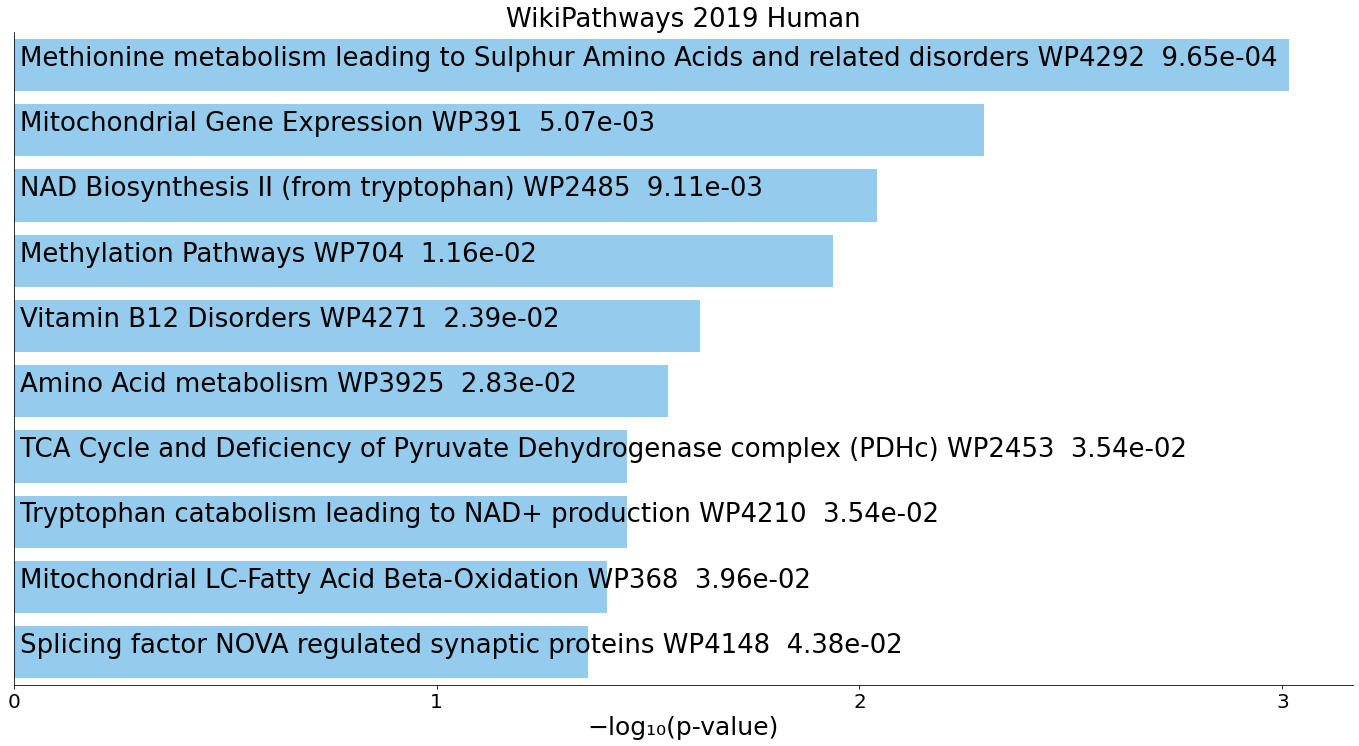

/Users/maayanlab/Desktop/Enrichment_Appyter/Enrichr_results_bar.png

/Users/maayanlab/Desktop/Enrichment_Appyter/Enrichr_results_bar.svg

In [13]:
# Display Bar Chart
try:
    results = Enrichr_API(genes, [enrichr_library])
    enrichr_figure(results[2], results[3], results[4], final_output_file_names, [enrichr_library], color)
    # Download Bar Chart
    for i, file in enumerate(final_output_file_names):
        display(FileLink(file, result_html_prefix=str('Download ' + figure_file_format[i] + ': ')))
except APIFailure:
    results = []
    display(HTML("<div style='font-size:1.5rem; padding:1rem 0;'><b>Unable to display plot because of a bad response from the Enrichr API</b></div>"))
    display(HTML("<div style='font-size:1rem; padding:1rem 0;'>Please try again later."))
except NoResults:
    results = []
    display(HTML("<div style='font-size:1.5rem; padding:1rem 0;'><b>Unable to display plot because there were no results returned from Enrichr</b></div>"))
    display(HTML("<div style='font-size:1rem; padding:1rem 0;'>Please try again with a different Enrichr library, or a different query gene list."))

# Hexagonal Canvas

Each hexagon in the hexagonal canvas plot represents one gene set from the selected library. The hexagons are colored based on the Jaccard similarity index between the input gene list and the gene set represented by the hexagon, with brighter color indicating higher similarity. Hexagons that are grouped together represent similar gene sets. 

Hovering over a hexagon will display the name of the gene set and the associated similarity index. 

For creating customized hexagonal canvas plots for up to two libraries at once, use the standalone [Hexagonal Canvas Appyter](https://appyters.maayanlab.cloud/#Enrichr_Canvas_Appyter).

In [14]:
# Hexagonal Canvas Functions

def library_processing():
    # Downloads library data for the hexagonal canvas
    # Library data is pre-annealed so the canvas will have the most similar gene sets closest together
    raw_library_data = []

    try:
        library_name = enrichr_library
        with urllib.request.urlopen('https://raw.githubusercontent.com/MaayanLab/Enrichr-Viz-Appyter/master/Enrichr-Processed-Library-Storage/Annealing/Annealed-Libraries/' + library_name + '.txt') as f:
            for line in f.readlines():
                raw_library_data.append(line.decode('utf-8').split("\t\t"))
        name = []
        gene_list = []
    except:
        display(HTML("<div style='font-size:1.5rem; padding:1.5rem 0;'>Failed to retrieve the selected annealed library.</div>"))
        return [], -1, -1

    for i in range(len(raw_library_data)):
        name += [raw_library_data[i][0]]
        raw_genes = raw_library_data[i][1].split('\t')
        gene_list += [raw_genes[:-1]]

    library_data = [list(a) for a in zip(name, gene_list)]

    # raw_library_data: a 2D list where the first element is the name and the second element is a list of genes associated with that name

    jaccard_indices = []
    indices = []

    for gene_set in library_data:
        intersection = [value for value in gene_set[1] if value in genes]
        index = len(intersection)/(len(gene_set[1]) + len(genes))
        jaccard_indices += [[gene_set[0], index]]
        indices += [round(index, 5)]

    # determine the dimensions of the canvas
    x_dimension = math.ceil(math.sqrt(len(indices)))
    y_dimension = math.ceil(math.sqrt(len(indices)))

    # zip name, gene_list, indices, and blank list for neighbor score then add dummy entries to the zipped list
    anneal_list = list(zip(name, gene_list, indices))

    return anneal_list, x_dimension, y_dimension

def unzip_list(anneal_list):
    unzipped_list = zip(*anneal_list)
    return list(unzipped_list)

# define a list of colors for the hexagonal canvas
def get_color(anneal_list, cut_off_value, x_dimension, y_dimension):

    # Deal with cut_off_value (only color the most significant 10/20 hexagons)
    if cut_off_value == 2.0:
        sort_list = sorted(anneal_list, key=itemgetter(2), reverse=True)
        cut_off_value = sort_list[int(num_hex_colored)-1][2]

    r_value = 0
    g_value = 0
    b_value = 0

    if canvas_color == 'Red':
        r_value = 0.0
        g_value = 0.8
        b_value = 0.8
    if canvas_color == 'Yellow':
        r_value = 0.0
        g_value = 0.3
        b_value = 1.0
    if canvas_color == 'Purple':
        r_value = 0.5
        g_value = 1.0
        b_value = 0.0
    if canvas_color == 'Pink':
        r_value = 0.0
        g_value = 1.0
        b_value = 0.2
    if canvas_color == 'Orange':
        r_value = 0.0
        g_value = 0.45
        b_value = 1.0
    if canvas_color == 'Green':
        r_value = 1.0
        g_value = 0.0
        b_value = 1.0
    if canvas_color == 'Blue':
        r_value = 1.0
        g_value = 0.9
        b_value = 0.0

    color_list = []

    unzipped_anneal_list = unzip_list(anneal_list)

    max_index = max(unzipped_anneal_list[2])

    if max_index != 0:
        scaled_list = [i/max_index for i in unzipped_anneal_list[2]]
    else:
        scaled_list = unzipped_anneal_list[2]

    for i in range(x_dimension*y_dimension):
        if i < len(unzipped_anneal_list[2]) and float(unzipped_anneal_list[2][i]) >= cut_off_value:
            color_list += [mpl.colors.to_hex((1-scaled_list[i]*r_value, 
            1-scaled_list[i]*g_value, 1-scaled_list[i]*b_value))]
        elif i < len(unzipped_anneal_list[2]):
            color_list += [mpl.colors.to_hex((1-scaled_list[i], 
            1-scaled_list[i], 1-scaled_list[i]))]
        else:
            color_list += ["#FFFFFF"]
    return color_list, max_index, cut_off_value

def init_chart():
  chart_id = 'mychart-' + str(uuid.uuid4())
  display(HTML('<script src="/static/components/requirejs/require.js"></script>'))
  display(HTML(Template(dedent('''
  <script>
  require.config({
    paths: {
      'd3': 'https://cdnjs.cloudflare.com/ajax/libs/d3/5.16.0/d3.min',
      'd3-hexbin': 'https://d3js.org/d3-hexbin.v0.2.min',
    },
    shim: {
      'd3-hexbin': ['d3']
    }
  })

  // If we configure mychart via url, we can eliminate this define here
  define($chart_id, ['d3', 'd3-hexbin'], function(d3, d3_hexbin) {
    return function (figure_id, numA, numB, colorList, libraryList, indices) {
      var margin = {top: 50, right: 20, bottom: 20, left: 50},
        width = 850 - margin.left - margin.right,
        height = 350 - margin.top - margin.bottom;

      // append the svg object to the body of the page
      var svG = d3.select('#' + figure_id)
                  .attr("width", width + margin.left + margin.right)
                  .attr("height", height + margin.top + margin.bottom)
                  .append("g")
                  .attr("transform", "translate(" + margin.left + "," + margin.top + ")");
      
      //The number of columns and rows of the heatmap
      var MapColumns = numA,
          MapRows = numB;

      //The maximum radius the hexagons can have to still fit the screen
      var hexRadius = d3.min([width/((MapColumns + 0.5) * Math.sqrt(3)), height/((MapRows + 1/3) * 1.5)]);

      //Calculate the center position of each hexagon
      var points = [];
      for (var i = 0; i < MapRows; i++) {
          for (var j = 0; j < MapColumns; j++) {
              var x = hexRadius * j * Math.sqrt(3)
              //Offset each uneven row by half of a "hex-width" to the right
              if(i%2 === 1) x += (hexRadius * Math.sqrt(3))/2
              var y = hexRadius * i * 1.5
              points.push([x,y])
          }
      }

      //Set the hexagon radius
      var hexbin = d3_hexbin.hexbin().radius(hexRadius);

      svG.append("g")
        .selectAll(".hexagon")
        .data(hexbin(points))
        .enter().append("path")
        .attr("class", "hexagon")
        .attr("d", function (d) {
            return "M" + d.x + "," + d.y + hexbin.hexagon();
        })
        .attr("stroke", "black")
        .attr("stroke-width", "1px")
        .style("fill", function (d,i) { return colorList[i]; })
        .on("mouseover", mover)
        .on("mouseout", mout)
        .append("svg:title")
        .text(function(d,i) { return libraryList[i].concat(" ").concat(indices[i]); });

      // Mouseover function
      function mover(d) {
      d3.select(this)
        .transition().duration(10)  
        .style("fill-opacity", 0.3)
      };

      // Mouseout function
      function mout(d) { 
      d3.select(this)
        .transition().duration(10)
        .style("fill-opacity", 1)
      };

  }

  })
  </script>
  ''')).substitute({ 'chart_id': repr(chart_id) })))
  return chart_id

def Canvas(numA, numB, colorList, libraryList, indices):
  chart_id = init_chart()
  display(HTML(Template(dedent('''
  <svg id=$figure_id></svg>
  <script>
  require([$chart_id], function(mychart) {
    mychart($figure_id, $numA, $numB, $colorList, $libraryList, $indices)
  })
  </script>
  ''')).substitute({
      'chart_id': repr(chart_id),
      'figure_id': repr('fig-' + str(uuid.uuid4())),
      'numA': repr(numA),
      'numB': repr(numB),
      'colorList': repr(colorList),
      'libraryList': repr(libraryList),
      'indices': repr(indices)
  })))

In [15]:
# Display Hexagonal Canvas
anneal_list, x_dimension, y_dimension = library_processing()
if x_dimension < 0:
    display(HTML("<div style='font-size:1rem;'>Unable to create hexagonal canvas visualization.</div>"))
else:
    color_list, scaling_factor, cut_off_value = get_color(anneal_list, 2.0, x_dimension, y_dimension)
    unzipped_anneal_list = unzip_list(anneal_list)
    if len(set(unzipped_anneal_list[2])) > 1:
        Canvas(x_dimension, y_dimension, color_list, list(unzipped_anneal_list[0]), list(unzipped_anneal_list[2]))
    else:
        display(HTML("<div style='font-size:1.5rem; padding:1rem 0;'><b>Unable to display plot because there were no results returned from Enrichr</b></div>"))
        display(HTML("<div style='font-size:1rem; padding:1rem 0;'>Please try again with a different Enrichr library, or a different query gene list."))

# Manhattan Plot

In the Manhattan plot below, each line on the x-axis denotes a single gene set from the selected library, while the y-axis measures the −log₁₀(p‐value) for each gene set. 

Hovering over a point will display the name of the gene set and the associated p-value. You can also zoom, pan, and save the plot as an svg using the toolbar on the right.

For creating customized static and dynamic Manhattan plots to compare multiple libraries at once, use the standalone [Manhattan Plot Appyter](https://appyters.maayanlab.cloud/#Enrichr_Manhattan_Plot).

In [16]:
# Manhattan Plot Functions

# Processes Enrichr data for Manhattan plots
def get_data(genes):
    # Process Enrichr data
    sorted_data = pd.DataFrame({"Gene Set": [], "-log(p value)": [], "Library": []})

    # get enrichr results from the library selected
    results_df = Enrichr_API(genes, [enrichr_library])[0]

    all_terms = []
    all_pvalues = []
    library_names = []

    all_terms.append(list(results_df[1]))
    all_pvalues.append(list(results_df[2]))
    library_names.append(list(results_df['library']))

    x=np.log10(all_pvalues[0])*-1
    sorted_terms = list(zip(all_terms[0], x, library_names[0]))
    sorted_terms = sorted(sorted_terms, key = itemgetter(0))
    unzipped_sorted_list = list(zip(*sorted_terms))

    data = pd.DataFrame({"Gene Set": unzipped_sorted_list[0], "-log(p value)": unzipped_sorted_list[1], "Library": unzipped_sorted_list[2]})

    sorted_data = pd.concat([sorted_data, data])

    # group data by library
    groups = sorted_data.groupby("Library")
    return sorted_data, groups

# Create Manhattan Plots
def manhattan(sorted_data):
    # split data frame into smaller data frames by library
    list_of_df = []
    for library_name in [enrichr_library]:
        library_name = library_name.replace('_', '')
        df_new = sorted_data[sorted_data['Library'] == library_name]
        list_of_df += [df_new]

    list_of_xaxis_values = []
    for df in list_of_df:  
        list_of_xaxis_values += df["Gene Set"].values.tolist()

    # define the output figure and the features we want
    p = figure(x_range = list_of_xaxis_values, plot_height=300, plot_width=750, tools='pan, box_zoom, hover, reset, save')

    # loop over all libraries
    r = []
    color_index = 0
    for df in list_of_df:
        if color_index >= len(manhattan_colors):
            color_index = 0 

        # calculate actual p value from -log(p value)
        actual_pvalues = []
        for log_value in df["-log(p value)"].values.tolist():
            actual_pvalues += ["{:.5e}".format(10**(-1*log_value))]

        # define ColumnDataSource with our data for this library
        source = ColumnDataSource(data=dict(
            x = df["Gene Set"].values.tolist(),
            y = df["-log(p value)"].values.tolist(),
            pvalue = actual_pvalues,
        ))
    
        # plot data from this library
        r += [p.circle(x = 'x', y = 'y', size=5, fill_color=manhattan_colors[color_index], line_color = manhattan_colors[color_index], line_width=1, source = source)]
        color_index += 1

    p.background_fill_color = 'white'
    p.xaxis.major_tick_line_color = None 
    p.xaxis.major_label_text_font_size = '0pt'
    p.y_range.start = 0
    p.yaxis.axis_label = '-log(p value)'

    p.hover.tooltips = [
        ("Gene Set", "@x"),
        ("p value", "@pvalue"),
    ]
    p.output_backend = "svg"
    
    # returns the plot
    return p

In [17]:
# Display Manhattan Plot
try:
    sorted_data, groups = get_data(genes)
    show(manhattan(sorted_data))
except APIFailure:
    display(HTML("<div style='font-size:1.5rem; padding:1rem 0;'><b>Unable to display plot because of a bad response from the Enrichr API</b></div>"))
    display(HTML("<div style='font-size:1rem; padding:1rem 0;'>Please try again later."))
except NoResults:
    display(HTML("<div style='font-size:1.5rem; padding:1rem 0;'><b>Unable to display plot because there were no results returned from Enrichr</b></div>"))
    display(HTML("<div style='font-size:1rem; padding:1rem 0;'>Please try again with a different Enrichr library, or a different query gene list."))

# Volcano Plot

The volcano plot shows the significance of each gene set from the selected library versus its odds ratio. Each point represents a single geneset; the x-axis measures the odds ratio (0, inf) calculated for the gene set, while the y-axis gives the -log(p-value) of the gene set. 

Larger blue points represent significant terms (p-value < 0.05); smaller gray points represent non-significant terms. The darker the blue color of a point, the more significant it is. 

Hovering over points will display the corresponding gene set term, the p-value, and the odds ratio. You may have to zoom in using the toolbar next to the plot in order to see details in densely-populated portions. Plots can also be downloaded as an svg using the save function on the toolbar.

In [18]:
def get_library(lib_name):
    '''
    Returns a dictionary mapping each term from the input library to 
    its associated geneset. 
    '''
    raw_lib_data = []

    with urllib.request.urlopen('https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=text&libraryName=' + lib_name) as f:
        for line in f.readlines():
            raw_lib_data.append(line.decode("utf-8").split("\t\t"))

    name = []
    gene_list = []
    lib_data = {}

    for i in range(len(raw_lib_data)):
        name += [raw_lib_data[i][0]]
        raw_genes = raw_lib_data[i][1].replace('\t', ' ')
        gene_list += [raw_genes[:-1]]
    
    lib_data = {a[0]:a[1].split(' ') for a in zip(name, gene_list)}
    return lib_data


def volcano_plot(library_name, lib):
    '''
    Make volcano plot of odds ratio vs. significance for input library.
    '''
    enrich_results = enrich_crisp(genes, lib, 21000, True)

    res_df = pd.DataFrame(
        [ [
            term, 
            res.pvalue, 
            res.odds_ratio
        ] for (term, res) in enrich_results ], 
        columns=['term', 'pvalue', 'odds_ratio']
    )

    res_df['log_pval'] = np.negative(np.log10(res_df['pvalue']))

    cmap = mpl.cm.get_cmap('Blues_r')
    cnorm = colors.Normalize(vmin = res_df['pvalue'].min(), vmax = 0.1)

    my_colors = []
    my_sizes = []
    for row in res_df.itertuples():
        if row.pvalue < 0.05:
            my_colors += [mpl.colors.to_hex(cmap(cnorm(row.pvalue)))]
            my_sizes += [12]
        else:
            my_colors += ['#808080']
            my_sizes += [6]

    source = ColumnDataSource(
        data=dict(
            x = res_df['odds_ratio'],
            y = res_df['log_pval'],
            gene_set = res_df['term'],
            p_value = res_df['pvalue'],
            odds_r = res_df['odds_ratio'],
            colors = my_colors,
            sizes = my_sizes
        )
    )

    hover_emb = HoverTool(
        names=["res_df"], 
        tooltips="""
        <div style="margin: 10">
            <div style="margin: 0 auto; width:200px;">
                <span style="font-size: 12px; font-weight: bold;">Term:</span>
                <span style="font-size: 12px">@gene_set<br></span>
                <span style="font-size: 12px; font-weight: bold;">P-Value:</span>
                <span style="font-size: 12px">@p_value<br></span>
                <span style="font-size: 12px; font-weight: bold;">Odds Ratio:</span>
                <span style="font-size: 12px">@odds_r<br></span>
            </div>
        </div>
        """
    )

    tools_emb = [hover_emb, 'pan', 'wheel_zoom', 'reset', 'save']

    plot_emb = figure(
        plot_width = 700, 
        plot_height = 700,
        tools=tools_emb
    )

    plot_emb.circle(
        'x', 'y', size = 'sizes', 
        alpha = 0.7, line_alpha = 0, 
        line_width = 0.01, source = source, 
        fill_color = 'colors', name = "res_df"
    )

    plot_emb.xaxis.axis_label = "Odds Ratio"
    plot_emb.yaxis.axis_label = "-log10(p-value)"

    plot_emb.output_backend = "svg"
    
    return plot_emb

In [19]:
lib_data = get_library(enrichr_library)
if lib_data == {}:
    display(HTML("<div style='font-size:1.5rem; padding:1.5rem 0;'>Failed to access Enrichr library API, please try again later.</div>"))
else:
    try:
        plot = volcano_plot(enrichr_library, lib_data)
        show(plot)
    except NoResults:
        display(HTML("<div style='font-size:1.5rem; padding:1rem 0;'><b>Unable to display plot because there were no results returned from Enrichr</b></div>"))
        display(HTML("<div style='font-size:1rem; padding:1rem 0;'>Please try again with a different Enrichr library, or a different query gene list."))

# Table of significant p-values

A downloadable table displaying the names, p-values, and q-values of significant terms in the selected library. The `q-value` is an adjusted p-value calculated using the Benjamini-Hochberg method for correction for multiple hypotheses testing. Only the top 10 significant results are displayed in this notebook, but the full table containing all significant results can be downloaded using the *Download CSV file of the full table of significant results* link.

In [20]:
# Output a table of significant p-values and q-values

def create_download_link(df, title = "Download CSV file of the full table of significant results", filename = "Enrichment_Analysis_Visualizer_data.csv"):  
    csv = df.to_csv(filename, index = False)
    html = f'<a href="{filename}" target=_blank>{title}</a>'
    return HTML(html)

if len(results) > 0:
    res_df = pd.DataFrame(results[0]).rename(columns={
        0: 'rank',
        1: 'term',
        2: 'p-value',
        3: 'zscore',
        4: 'combined_score',
        5: 'overlap_genes',
        6: 'q-value'
    })
    sorted_res_df = res_df.sort_values(by='p-value', ascending=True)
    filtered_res_df = sorted_res_df[sorted_res_df['p-value'] <= significance_value].reset_index()
    display(HTML(f"<strong>Table of top 10 significant p-values and q-values for {enrichr_library.replace('_', ' ')}</strong>"))
    display(HTML(filtered_res_df[['term', 'p-value', 'q-value']][:10].to_html(index = False)))
    display(create_download_link(filtered_res_df[['term', 'p-value', 'q-value']]))
else:
    display(HTML("<div style='font-size:1.5rem; padding:1rem 0;'><b>Unable to display table</b></div>"))
    display(HTML("<div style='font-size:1rem; padding:1rem 0;'>Please try again later, or start over with a new input list and/or library."))

term,p-value,q-value
Methionine metabolism leading to Sulphur Amino Acids and related disorders WP4292,0.000965,0.178473
Mitochondrial Gene Expression WP391,0.005069,0.468912
NAD Biosynthesis II (from tryptophan) WP2485,0.009110,0.535073
Methylation Pathways WP704,0.011569,0.535073
Vitamin B12 Disorders WP4271,0.023859,0.810979
Amino Acid metabolism WP3925,0.028302,0.810979
TCA Cycle and Deficiency of Pyruvate Dehydrogenase complex (PDHc) WP2453,0.035378,0.810979
Tryptophan catabolism leading to NAD+ production WP4210,0.035378,0.810979
Mitochondrial LC-Fatty Acid Beta-Oxidation WP368,0.039608,0.810979
Splicing factor NOVA regulated synaptic proteins WP4148,0.043837,0.810979


# Link to Enrichr

In [21]:
# Get complete enrichment analysis results from Enrichr 
if len(results) > 0:
    url = 'https://maayanlab.cloud/Enrichr/enrich?dataset=' + results[5]
    display(HTML(f"<div style='font-size:1.25rem; padding:1rem 0;'><a href='https://maayanlab.cloud/Enrichr/enrich?dataset={results[5]}'>Access the complete enrichment analysis results on the Enrichr website. </a></div>"))
else:
    display(HTML("<div style='font-size:1.5rem; padding:1rem 0;'><b>No Enrichr results available for the current query</b></div>"))
    display(HTML("<div style='font-size:1rem; padding:1rem 0;'>Please try again with a different input list and/or library."))